In [9]:
from IPython.display import Markdown, display
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.losses import MeanSquaredLogarithmicError
from keras.layers import Input, Dense, Dropout
from keras.models import Sequential

In [10]:
# Display options
pd.set_option('display.max_columns', None)

# Matplotlib configuration
plt.style.use('classic')

In [11]:
# Auxiliary functions

def one_hot_encode_dataset(data: pd.DataFrame) -> pd.DataFrame:
    """
    One-hot encodes categorical variables in the dataset.

    Parameters:
    data (pd.DataFrame): Input dataset.

    Returns:
    pd.DataFrame: Encoded dataset.
    """
    # Identify categorical variables
    categorical_features = data.select_dtypes(include=['object']).columns

    # Apply one-hot encoding to the categorical variables
    encoded_data = pd.get_dummies(data, columns=categorical_features)

    return encoded_data


def map_categorical_features(data: pd.DataFrame) -> pd.DataFrame:
    """
    Maps categorical features in the dataset to predefined categories.

    Parameters:
    data (pd.DataFrame): Input dataset.

    Returns:
    pd.DataFrame: Dataset with mapped categorical features.
    """
    # Define mappings
    MSSubClass_mapping = {
        20: '1-STORY 1946 & NEWER ALL STYLES',
        30: '1-STORY 1945 & OLDER',
        40: '1-STORY W/FINISHED ATTIC ALL AGES',
        45: '1-1/2 STORY - UNFINISHED ALL AGES',
        50: '1-1/2 STORY FINISHED ALL AGES',
        60: '2-STORY 1946 & NEWER',
        70: '2-STORY 1945 & OLDER',
        75: '2-1/2 STORY ALL AGES',
        80: 'SPLIT OR MULTI-LEVEL',
        85: 'SPLIT FOYER',
        90: 'DUPLEX - ALL STYLES AND AGES',
        120: '1-STORY PUD (Planned Unit Development) - 1946 & NEWER',
        150: '1-1/2 STORY PUD - ALL AGES',
        160: '2-STORY PUD - 1946 & NEWER',
        180: 'PUD - MULTILEVEL - INCL SPLIT LEV/FOYER',
        190: '2 FAMILY CONVERSION - ALL STYLES AND AGES'
    }

    OverallQual_mapping = {
        10: 'Very Excellent',
        9: 'Excellent',
        8: 'Very Good',
        7: 'Good',
        6: 'Above Average',
        5: 'Average',
        4: 'Below Average',
        3: 'Fair',
        2: 'Poor',
        1: 'Very Poor'
    }

    OverallCond_mapping = OverallQual_mapping

    # Apply mappings
    data['MSSubClass'] = data['MSSubClass'].map(MSSubClass_mapping)
    data['OverallQual'] = data['OverallQual'].map(OverallQual_mapping)
    data['OverallCond'] = data['OverallCond'].map(OverallCond_mapping)

    return data


def build_model(input_dim, output_dim):
    """
    Function to build a sequential deep neural network model.

    Args:
    input_dim (int): Dimensionality of the input data.
    output_dim (int): Dimensionality of the output data.

    Returns:
    keras.Sequential: Compiled deep neural network model.

    """

    # Build sequential model
    model = models.Sequential(name="ImprovedSalesPricePredictionModel")
    
    # Add input layer
    input_layer = Input(shape=(input_dim,), name="InputLayer")
    
    # Add first hidden layer
    model.add(Dense(units=100, activation='relu', name="Hidden-1"))
    
    # Add second hidden layer
    model.add(Dense(units=150, activation='relu', name='Hidden-2'))
    
    # Add third hidden layer
    model.add(Dense(units=150, activation='relu', name='Hidden-3'))
    
    # Add dropout layer to prevent overfitting
    model.add(Dropout(rate=0.1, name='Dropout-layer'))
    
    # Add fourth hidden layer
    model.add(Dense(units=100, activation='relu', name='Hidden-4'))
    
    # Add fifth hidden layer
    model.add(Dense(units=50, activation='relu', name='Hidden-5'))
    
    # Add output layer
    model.add(Dense(units=output_dim, activation='linear', name='OutputLayer'))

    # Loss function
    loss = keras.losses.MeanSquaredLogarithmicError(
    reduction="sum_over_batch_size", name="mean_squared_logarithmic_error")

    # Validation metric
    r2_metric = tf.keras.metrics.R2Score(
    class_aggregation='uniform_average',
    num_regressors=0,
    name='r2_score',
    dtype=tf.float32)
    
    # Model configuration and compilation
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4, clipnorm=1.0, momentum=0.9)
    model.compile(optimizer=optimizer, loss=loss, metrics=[r2_metric])

    # Print model summary
    print(model.summary())

    return model
    

In [12]:
# Load train dataset
df = pd.read_csv('../data/train.csv')

# TRAIN MODEL
# ------------------------------------------------------------------
# Split data into features (X) and target variable (Y)
X_train = df.drop(columns=['Id', 'SalePrice'])
Y_train = df['SalePrice']

# Map dataset values to strings
X_train = map_categorical_features(X_train)

# Perform one-hot encoding on the predictor variables
X_train = one_hot_encode_dataset(X_train)

# Convert null values to zero
X_train = X_train.fillna(0)
Y_train = Y_train.fillna(0)

print(Y_train.shape)
print(X_train.shape)

# Build sequential model
model = build_model(X_train.shape[1], 1)

# Fit the model to the training data
early_stop_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=200, restore_best_weights=True)
model.fit(X_train.astype(np.float64), Y_train.astype(np.float64), batch_size=20, epochs=4000, shuffle=False, verbose=2, validation_split=0.15, callbacks=[early_stop_callback])


(1460,)
(1460, 318)


Model: "ImprovedSalesPricePredictionModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Hidden-1 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Hidden-2 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Hidden-3 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout-layer (Dropout)              │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Hidden-4 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Hidden-5 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ OutputLayer (Dense)                  │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/4000
63/63 - 2s - 27ms/step - loss: 31.5677 - r2_score: -5.0076e+00 - val_loss: 24.6133 - val_r2_score: -6.0283e+00
Epoch 2/4000
63/63 - 0s - 2ms/step - loss: 21.2442 - r2_score: -4.9368e+00 - val_loss: 17.8431 - val_r2_score: -5.9271e+00
Epoch 3/4000
63/63 - 0s - 2ms/step - loss: 15.7704 - r2_score: -4.8353e+00 - val_loss: 13.3573 - val_r2_score: -5.7794e+00
Epoch 4/4000
63/63 - 0s - 2ms/step - loss: 11.8316 - r2_score: -4.6833e+00 - val_loss: 10.0323 - val_r2_score: -5.5685e+00
Epoch 5/4000
63/63 - 0s - 2ms/step - loss: 8.8402 - r2_score: -4.4732e+00 - val_loss: 7.4804 - val_r2_score: -5.2788e+00
Epoch 6/4000
63/63 - 0s - 2ms/step - loss: 6.5538 - r2_score: -4.1965e+00 - val_loss: 5.4863 - val_r2_score: -4.8927e+00
Epoch 7/4000
63/63 - 0s - 2ms/step - loss: 4.7468 - r2_score: -3.8284e+00 - val_loss: 3.9335 - val_r2_score: -4.4003e+00
Epoch 8/4000
63/63 - 0s - 2ms/step - loss: 3.3803 - r2_score: -3.3889e+00 - val_loss: 2.7318 - val_r2_score: -3.7977e+00
Epoch 9/4000
63/63

In [13]:
# TEST MODEL
# ------------------------------------------------------------------
# Load test dataset
Xtest = pd.read_csv('../data/test.csv')

# Drop 'Id' column
X_test = Xtest.drop(columns=['Id'])

# Map dataset values to strings
X_test = map_categorical_features(X_test)

# Perform one-hot encoding on the predictor variables
X_test = one_hot_encode_dataset(X_test)

# Convert null values to zero
X_test = X_test.fillna(0)

# Map features in validation dataset to match the features in training dataset
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# Generate predictions based on trained model
predictions = model.predict(X_test.astype(np.float32))

# Save predicted prices for submission as CSV file
submission_df = pd.DataFrame({'Id': Xtest['Id'], 
                              'SalePrice': np.squeeze(predictions)})
submission_df.to_csv('../submission/FFDNN_submission.csv', index=False)

# Log message
print("Submission file successfully created!")

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Submission file successfully created!


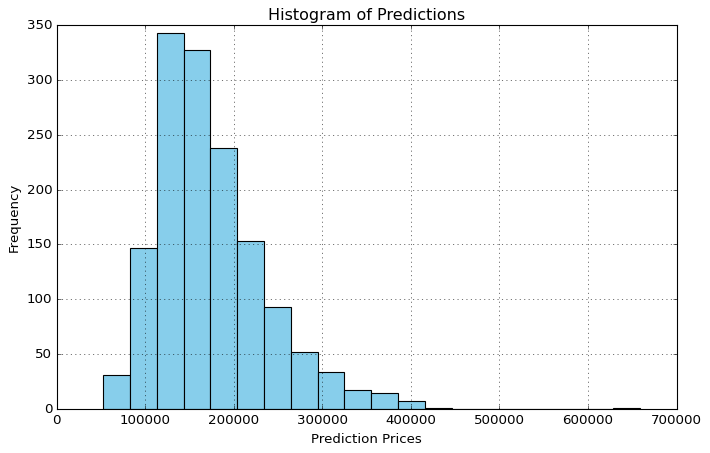

In [14]:
# Plot histogram for prediction values
plt.figure(facecolor='white', figsize=(10, 6))
plt.hist(predictions, bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of Predictions')
plt.xlabel('Prediction Prices')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()